# RAG Experimentation - RAG_CATEGORY

## Introduction
This notebook focuses on experimenting with RAG_CATEGORY Retrieval-Augmented Generation (RAG) method. The primary goal is to empirically evaluate its performance based on [TruERA RAG evaluation framework](https://truera.com/ai-quality-education/generative-ai-rags/what-is-the-rag-triad/):

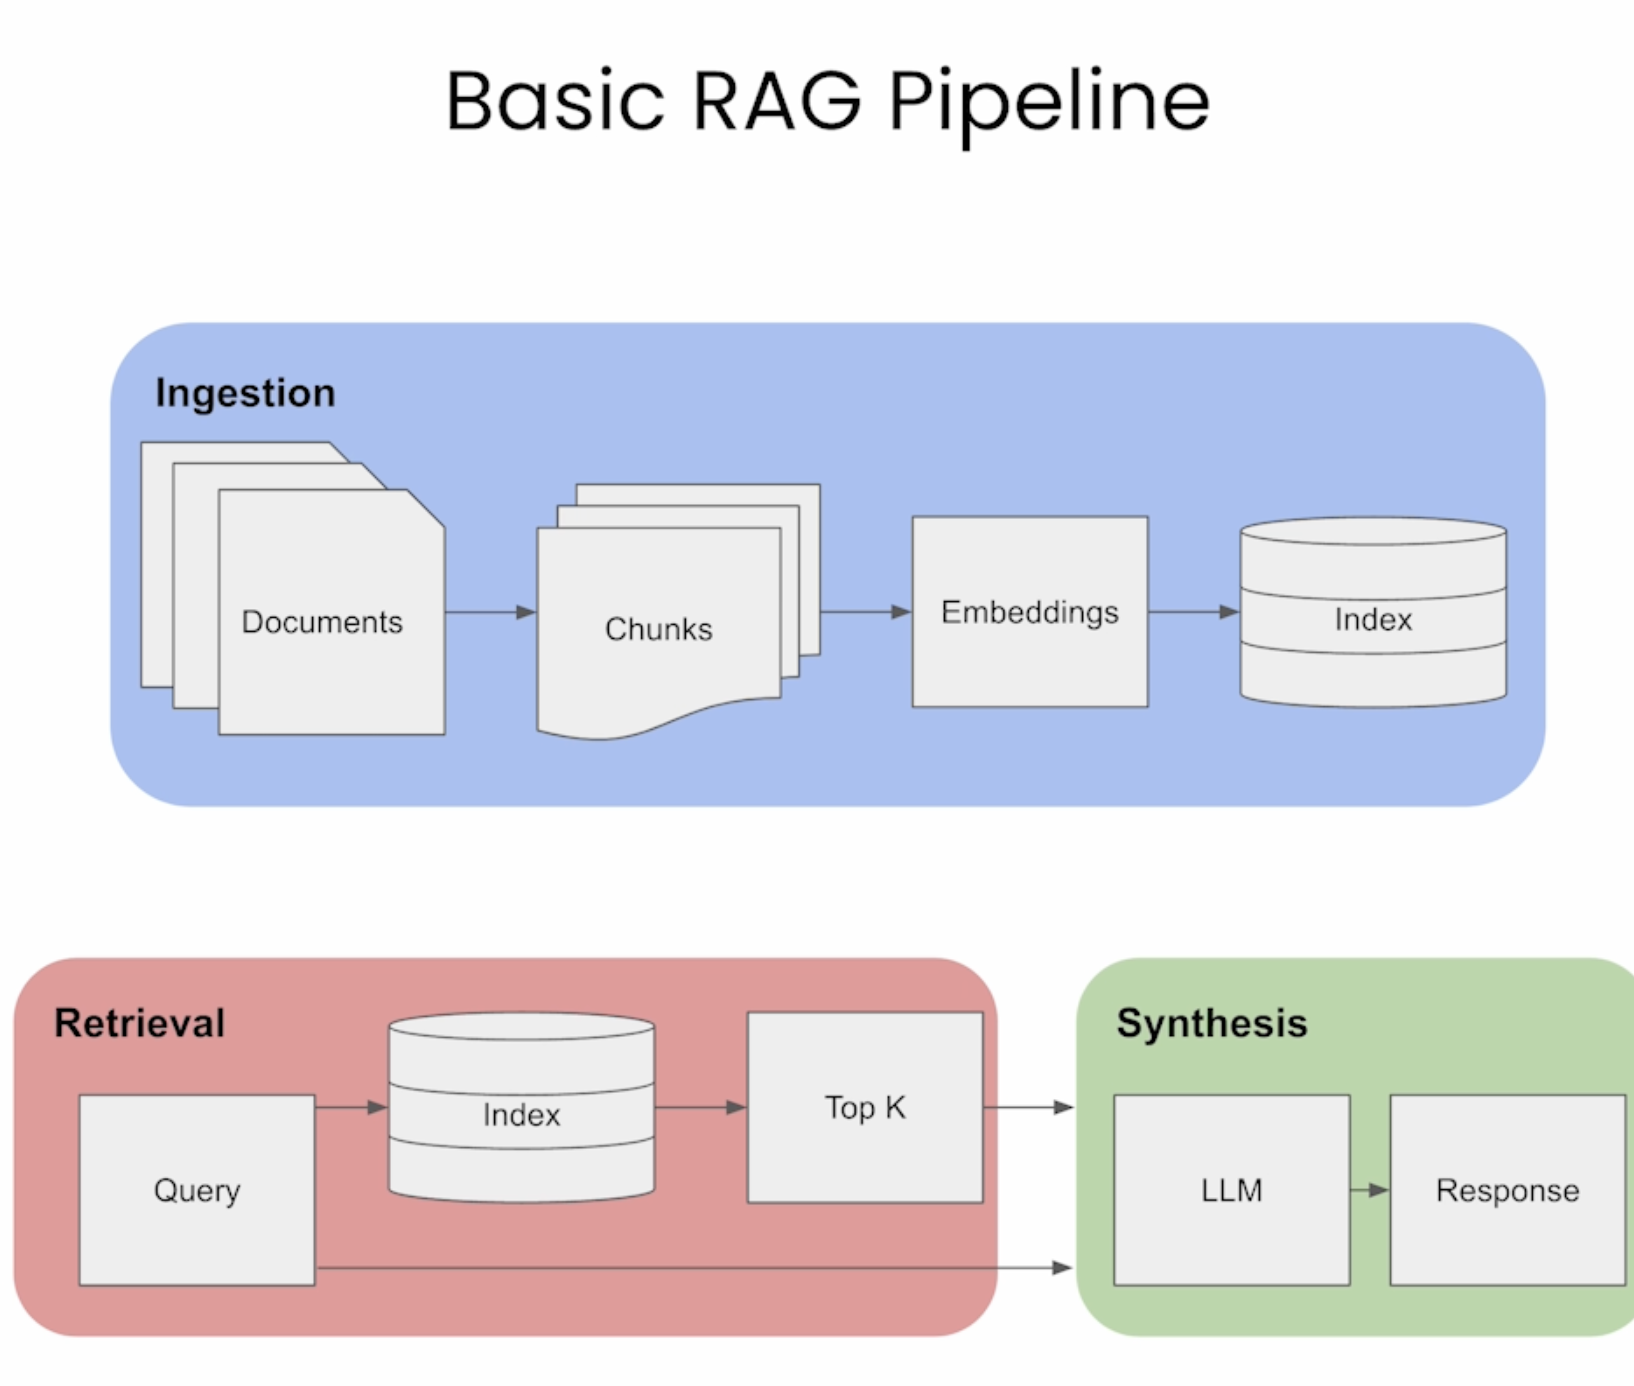


We adhere to the **conventional RAG pipeline** defined by the research community, which integrates retrieval systems with generative models. This structured approach ensures a comprehensive evaluation of the RAG_CATEGORY effectiveness in delivering accurate, context-aware outputs.Through this experimentation, we aim to identify its strengths and weaknesses in order to determine which RAG techniques is better to be used in our Specialist bot project.

## Ingestion

In [2]:
from llama_index.readers.file import PDFReader

documents = PDFReader().load_data("assets/pdf/fundamentals-data-engineering-chap1.pdf")

In [3]:
documents[0]

Document(id_='00e6f3ba-2b93-471c-b449-2506ac5370e4', embedding=None, metadata={'page_label': '1', 'file_name': 'fundamentals-data-engineering-chap1.pdf'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text='978-1-098-10830-4\n[LSI]\nFundamentals of Data Engineering\nby Joe Reis and Matt Housley\nCopyright © 2022 Joseph Reis and Matthew Housley. All rights reserved.\nPrinted in the United States of America.\nPublished by O’Reilly Media, Inc., 1005 Gravenstein Highway North, Sebastopol, CA 95472.\nO’Reilly books may be purchased for educational, business, or sales promotional use. Online editions are\nalso available for most titles (http://oreilly.com). For more information, contact our corporate/institutional\nsales department: 800-998-9938 or corporate@oreilly.com.\nAcquisitions Editor: Jessica Haberman\nDevelopment Editor: Michele Cronin\nProduction Editor: Gregory Hyman\nCopyeditor: Sharo

### Generate QA and ground of truth dataset

In [3]:
#toogle comment if you not generate qa dataset yet
# !python scripts/generate_questions.py

## Auto-merging retrieval setup

In [19]:
from llama_index.core.schema import Document
from llama_index.core.node_parser import HierarchicalNodeParser
from llama_index.core.node_parser import get_leaf_nodes

document = Document(text="\n\n".join([doc.text for doc in documents]))
node_parser = HierarchicalNodeParser.from_defaults(
    chunk_sizes=[2048, 512, 128]
)

nodes = node_parser.get_nodes_from_documents([document])
leaf_nodes = get_leaf_nodes(nodes)
print(leaf_nodes[205].text)

363
Orchestration


In [25]:
nodes_by_id = {node.node_id: node for node in nodes}

parent_node = nodes_by_id[leaf_nodes[300].parent_node.node_id]
print(parent_node.text)

We view the present as a golden age of data lifecycle management. Data engineers
managing the data engineering lifecycle have better tools and techniques than ever
before. We discuss the data engineering lifecycle and its undercurrents in greater
detail in the next chapter.
Data Engineering and Data Science
Where does data engineering fit in with data science? There’s some debate, with some
arguing data engineering is a subdiscipline of data science. We believe data engineer‐
ing is separate from data science and analytics. They complement each other, but they
are distinctly different. Data engineering sits upstream from data science (Figure 1-4),
meaning data engineers provide the inputs used by data scientists (downstream from
data engineering), who convert these inputs into something useful.
Figure 1-4. Data engineering sits upstream from data science
Consider the Data Science Hierarchy of Needs ( Figure 1-5). In 2017, Monica Rogati
published this hierarchy in an article  that showe

## Retrieval and Sinthesis

In [33]:
from llama_index.core.prompts import LangchainPromptTemplate
from IPython.display import Markdown, display
from langchain import hub
from llama_index.core.storage.docstore import SimpleDocumentStore
from llama_index.core import StorageContext
from llama_index.core import VectorStoreIndex
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.llms.openai import OpenAI
from llama_index.core.retrievers import AutoMergingRetriever
import dotenv

dotenv.load_dotenv("../.env")
docstore = SimpleDocumentStore()
docstore.add_documents(nodes)
storage_context = StorageContext.from_defaults(docstore=docstore)



base_index = VectorStoreIndex(
    leaf_nodes,
    storage_context=storage_context,
)

LLM_MODEL="gpt-4o-mini"
llm = OpenAI(model=LLM_MODEL, temperature=0.1)

node_parser = HierarchicalNodeParser.from_defaults(
    chunk_sizes=[2048, 512, 128]
)

base_retriever = base_index.as_retriever(similarity_top_k=6)
retriever = AutoMergingRetriever(base_retriever, storage_context, verbose=True)
langchain_prompt = hub.pull("rlm/rag-prompt")

lc_prompt_tmpl = LangchainPromptTemplate(
    template=langchain_prompt,
    template_var_mappings={"query_str": "question", "context_str": "context"},
)


query_engine = RetrieverQueryEngine.from_args(retriever)
base_query_engine = RetrieverQueryEngine.from_args(base_retriever)

/Users/Lucas.Silva/projects/bot-especialist/.venv/lib/python3.9/site-packages/langsmith/client.py:261: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [34]:
response=query_engine.query("What is Data engineering").response
display(Markdown(f"## Response \n\n > {response}"))

## Response 

 > Data engineering involves the development, implementation, and maintenance of systems and processes that transform raw data into high-quality, consistent information to support downstream use cases like analysis and machine learning. Data engineers manage the data engineering lifecycle, starting from obtaining data from source systems to delivering data for various use cases such as analysis or machine learning.

## Evalution

### Evaluation Methodology

To assess the RAG models, we utilize the **RAG TRIAD evaluation framework** from TRuERA, implemented via the **TruLens library**. This robust methodology allows for a thorough and detailed evaluation of model performance:

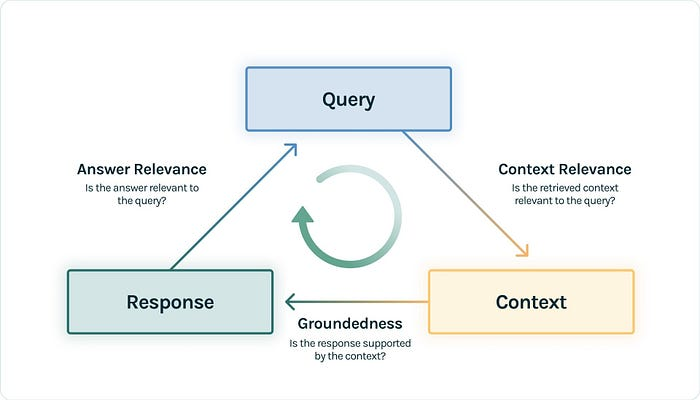


We're gonna use the following evaluations criteria include the following:

1. **Accuracy of Answers**  
   - Manually evaluated by a human.
   
2. **Context Relevance**  
   - Automatically generated metric based on LLM evaluation.

3. **Answer Relevance**  
   - Automatically generated metric based on LLM evaluation.

4. **Groundedness**  
   - Automatically generated metric based on LLM evaluation.

5. **Explainability and Traceability of Context Retrieval**  
   - Assessed through the TruLens dashboard and cross-validation between manual evaluations and automated metrics.

In [35]:
from trulens.apps.llamaindex import TruLlama
from trulens.providers.openai import OpenAI
from trulens.feedback.v2.feedback import Groundedness
from trulens.core.feedback import Feedback
from trulens.core.app import App
import numpy as np


In [36]:

provider = OpenAI(model_engine=LLM_MODEL)
groundedness_openai = Groundedness(groundedness_provider=provider)

context = App.select_context(query_engine)

f_context_relevance = (
    Feedback(provider.context_relevance_with_cot_reasons)
    .on_input()
    .on(context)  # Refers to context defined from `select_context`
    .aggregate(np.mean)
)

f_qa_relevance = Feedback(
    provider.relevance_with_cot_reasons,
    name="Answer Relevance"
).on_input_output()



f_groundedness = (
    Feedback(
        provider.groundedness_measure_with_cot_reasons,
        name=f"Groundedness OpenAI {LLM_MODEL}",
    )
    .on_input()
    .on_output()
    .aggregate(np.mean)
)


tru_query_engine_recorder = TruLlama(query_engine,
    app_id='LlamaIndex_App2',
    feedbacks=[f_groundedness, f_qa_relevance, f_context_relevance])



🦑 Initialized with db url sqlite:///default.sqlite .
🛑 Secret keys may be written to the database. See the `database_redact_keys` option of `TruSession` to prevent this.
✅ In context_relevance_with_cot_reasons, input question will be set to __record__.main_input or `Select.RecordInput` .
✅ In context_relevance_with_cot_reasons, input context will be set to __record__.calls[-1].rets.source_nodes[:].node.text .
✅ In Answer Relevance, input prompt will be set to __record__.main_input or `Select.RecordInput` .
✅ In Answer Relevance, input response will be set to __record__.main_output or `Select.RecordOutput` .
✅ In Groundedness OpenAI gpt-4o-mini, input source will be set to __record__.main_input or `Select.RecordInput` .
✅ In Groundedness OpenAI gpt-4o-mini, input statement will be set to __record__.main_output or `Select.RecordOutput` .


Exception in thread manage_pending_feedback_results_thread(app_name=LlamaIndex_App2, app_version=base):
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/Users/Lucas.Silva/projects/bot-especialist/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/opt/homebrew/Cellar/python@3.9/3.9.20/Frameworks/Python.framework/Versions/3.9/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/Lucas.Silva/projects/bot-especialist/.venv/lib/python3.9/site-packages/trulens/core/utils/python.py", line 621, in _future_target_wrapper
    return func(*args, **kwargs)
  File "/Users/Lucas.Silva/projects/bot-especialist/.venv/lib/python3.9/site-packages/trulens/core/app.py", line 501, in _manage_pending_feedback_results
    record.w

In [37]:
import json
from trulens.core import TruSession


tru = TruSession()
tru.reset_database()


with open('assets/json/QA_groundTruth.json', 'r') as file:
    questions_answers = json.load(file)


with tru_query_engine_recorder as recording:
    for qa in questions_answers:
        response = query_engine.query(qa["question"])
        

feedback = tru.get_records_and_feedback(app_ids=["LlamaIndex_App2"])
tru.run_dashboard()

Updating app_name and app_version in apps table: 0it [00:00, ?it/s]
Updating app_id in records table: 0it [00:00, ?it/s]
Updating app_json in apps table: 0it [00:00, ?it/s]


> Merging 3 nodes into parent node.
> Parent node id: 1d184b5f-77be-4d2d-9441-34f0165e8cb7.
> Parent node text: Instead, we
focus on the fundamental concepts behind data engineering.
What This Book Is About
Th...

> Merging 3 nodes into parent node.
> Parent node id: 1d184b5f-77be-4d2d-9441-34f0165e8cb7.
> Parent node text: Instead, we
focus on the fundamental concepts behind data engineering.
What This Book Is About
Th...

> Merging 3 nodes into parent node.
> Parent node id: 1d184b5f-77be-4d2d-9441-34f0165e8cb7.
> Parent node text: Instead, we
focus on the fundamental concepts behind data engineering.
What This Book Is About
Th...

> Merging 3 nodes into parent node.
> Parent node id: 1d184b5f-77be-4d2d-9441-34f0165e8cb7.
> Parent node text: Instead, we
focus on the fundamental concepts behind data engineering.
What This Book Is About
Th...

> Merging 1 nodes into parent node.
> Parent node id: 6e07622d-5410-4c53-b3d1-dfe4b6079abb.
> Parent node text: A data engineer
should have a go

/Users/Lucas.Silva/projects/bot-especialist/.venv/lib/python3.9/site-packages/trulens/feedback/llm_provider.py:286: UserWarning: No supporting evidence provided. Returning score only.
  warnings.warn(


> Merging 1 nodes into parent node.
> Parent node id: b5a494b0-4988-411f-a583-173aeffac9b7.
> Parent node text: Strive to understand how new technologies will be helpful in the lifecycle.
The Continuum of Data...

> Merging 1 nodes into parent node.
> Parent node id: b5a494b0-4988-411f-a583-173aeffac9b7.
> Parent node text: Strive to understand how new technologies will be helpful in the lifecycle.
The Continuum of Data...

> Merging 1 nodes into parent node.
> Parent node id: b5a494b0-4988-411f-a583-173aeffac9b7.
> Parent node text: Strive to understand how new technologies will be helpful in the lifecycle.
The Continuum of Data...

> Merging 1 nodes into parent node.
> Parent node id: 6e07622d-5410-4c53-b3d1-dfe4b6079abb.
> Parent node text: A data engineer
should have a good functioning understanding of these areas to serve stakeholders...

> Merging 1 nodes into parent node.
> Parent node id: 6e07622d-5410-4c53-b3d1-dfe4b6079abb.
> Parent node text: A data engineer
should have a go

/var/folders/92/nypxyrhd5jb8z0y5frdy8_dh0000gp/T/ipykernel_85473/2403829159.py:19: DeprecationWarning: Method `run_dashboard` has been renamed or moved to `trulens.dashboard.run.run_dashboard`.

  tru.run_dashboard()


Accordion(children=(VBox(children=(VBox(children=(Label(value='STDOUT'), Output())), VBox(children=(Label(valu…

Dashboard started at http://192.168.1.23:58066 .


<Popen: returncode: None args: ['streamlit', 'run', '--server.headless=True'...>

/Users/Lucas.Silva/projects/bot-especialist/.venv/lib/python3.9/site-packages/trulens/feedback/llm_provider.py:286: UserWarning: No supporting evidence provided. Returning score only.
  warnings.warn(
/Users/Lucas.Silva/projects/bot-especialist/.venv/lib/python3.9/site-packages/trulens/feedback/llm_provider.py:1521: UserWarning: Failed to process and remove trivial statements. Proceeding with all statements.
  warnings.warn(


## Conclusions
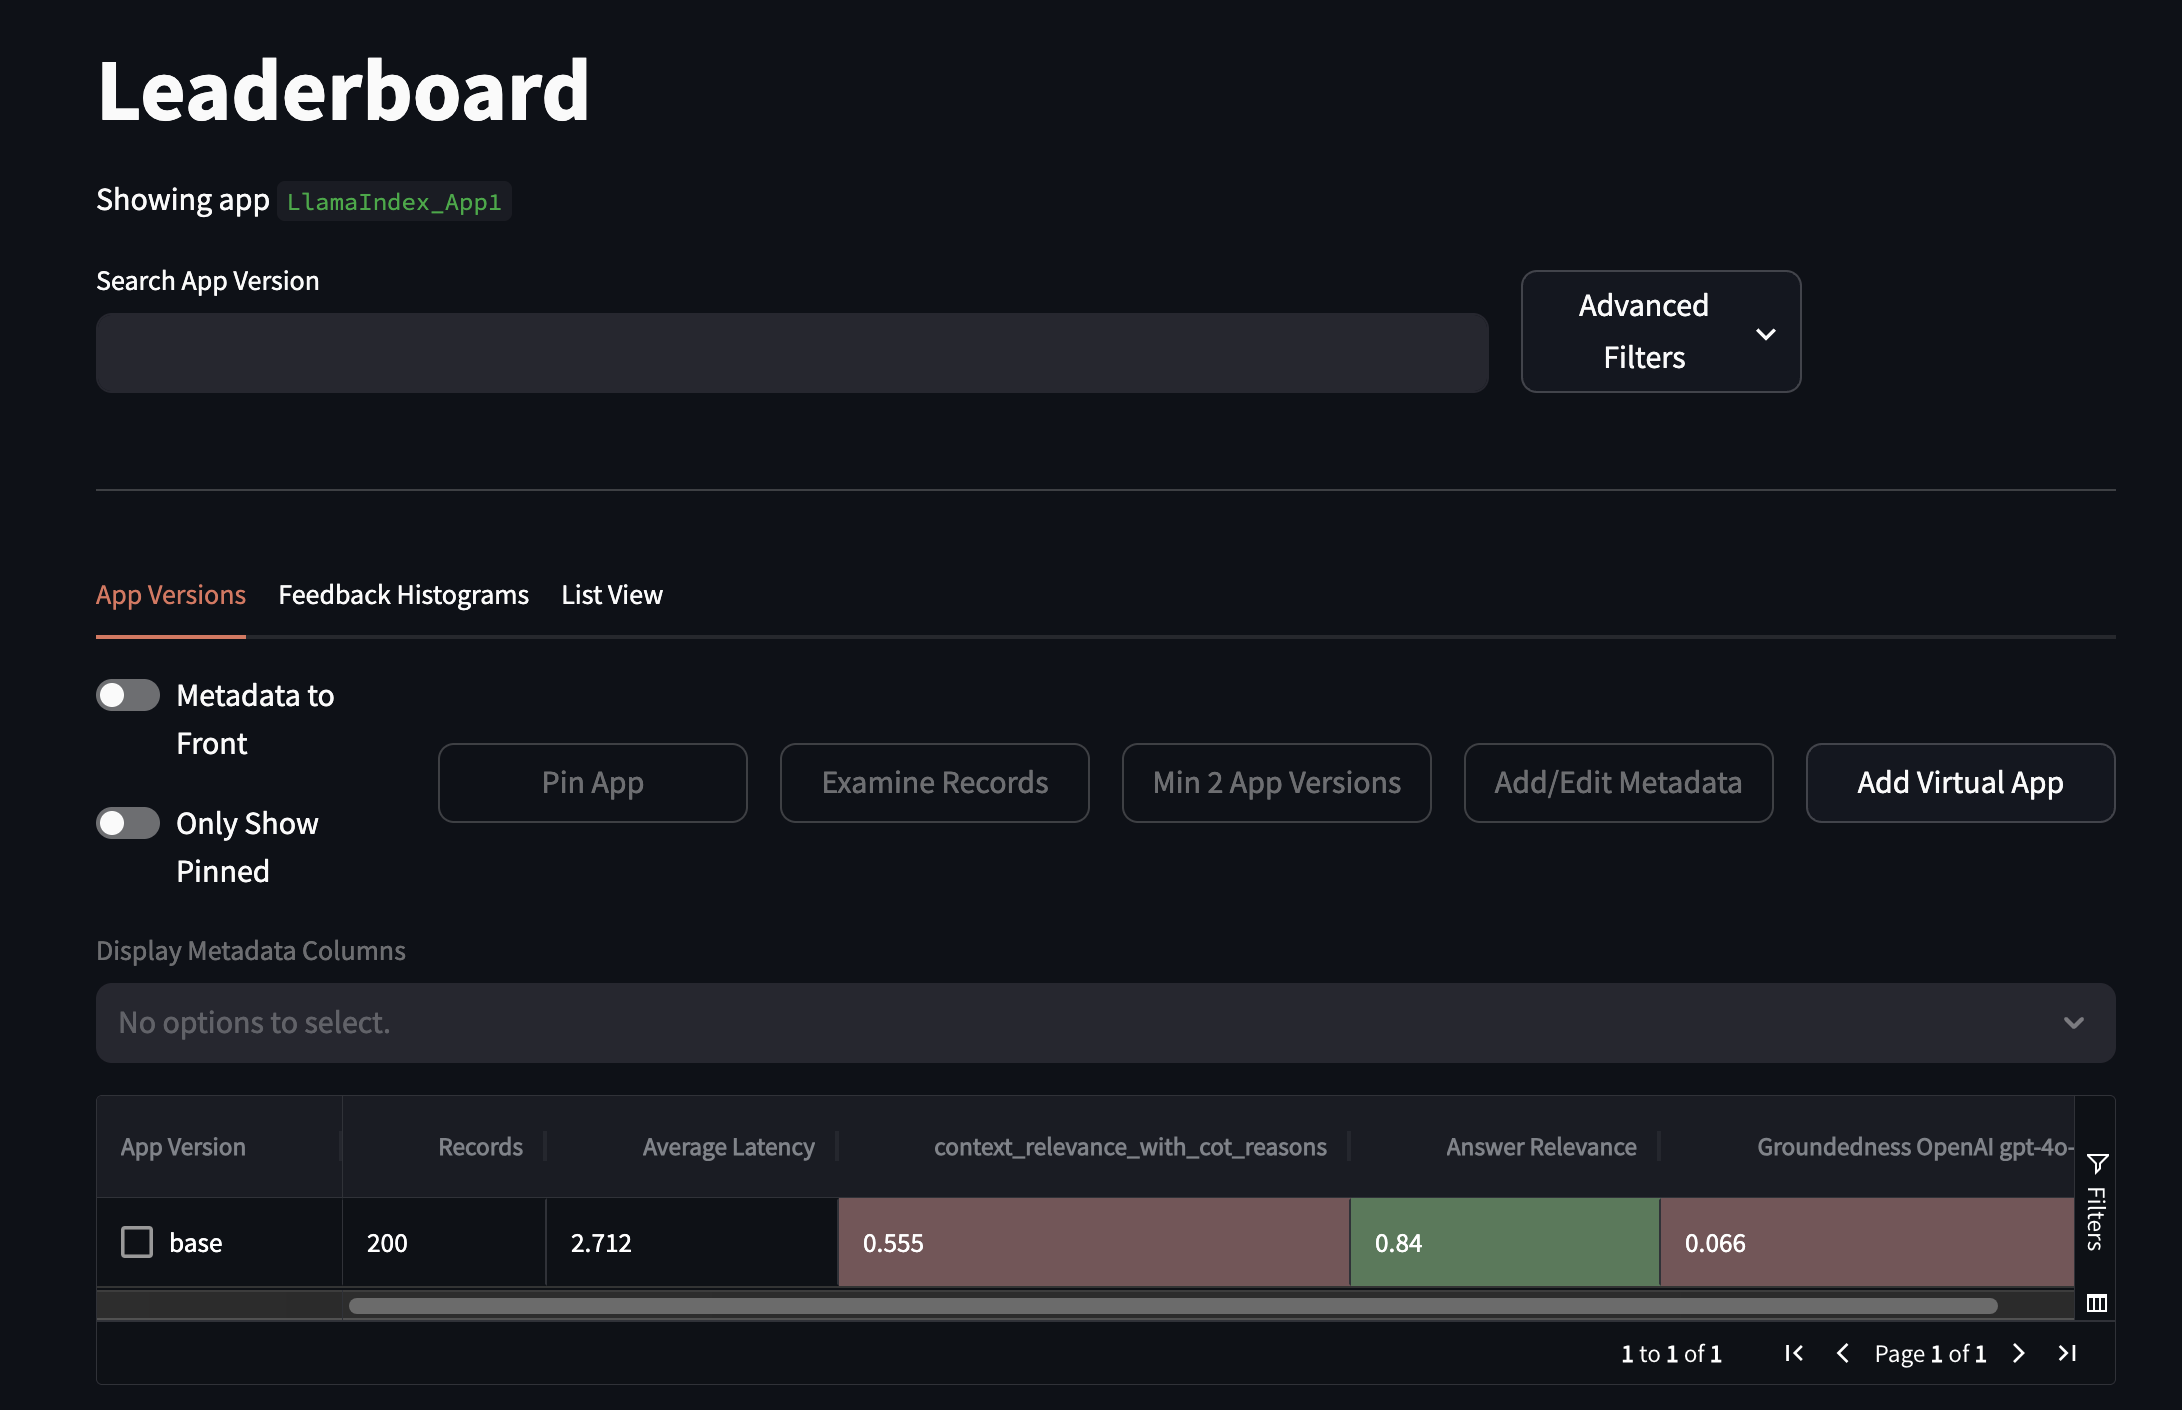

When used llangchain prompt template from hub, get improve on groundness, but still need some improvement on prompt